How is this measurement, reported by Canfranc, correlated with the background rate that we detect within NEXT-100 fiducial volume?

In [3]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis/libs')

import crudo
from   datetime import datetime
import fit_functions as ff
from   iminuit      import Minuit               # type: ignore
from   iminuit.cost import LeastSquares         # type: ignore
from   matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   PIL import Image                         # type: ignore
import plotting_tools as pt
import scipy

# Styling Plot
pt.ccortesp_plot_style()
PRELIM_LOGO = np.asarray(Image.open('/lhome/ific/c/ccortesp/Analysis/images/next_logo_preliminary.png'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminary

In [4]:
# List of low background runs
runs_info = {
                # May 2025
                # Condition 1:  castle = closed & RAS = on #
                # 15288: {"duration": 87256, "OK": 30201, "LOST": 8397 , "start": 1746808847, "end": 1746896103},
                # 15289: {"duration": 82152, "OK": 28180, "LOST": 7884 , "start": 1746896681, "end": 1746978833},
                # 15290: {"duration": 61295, "OK": 20931, "LOST": 5915 , "start": 1746979339, "end": 1747040634},
                # Condition 2:  castle = pclosed & RAS = off #
                15299: {"duration": 60204, "OK": 18014, "LOST": 8929 , "start": 1747064779, "end": 1747124983},
                15318: {"duration": 86706, "OK": 28735, "LOST": 10115, "start": 1747151055, "end": 1747237761},
                15319: {"duration": 85823, "OK": 27973, "LOST": 10086, "start": 1747237911, "end": 1747323734},
                15330: {"duration": 86462, "OK": 28157, "LOST": 10432, "start": 1747661369, "end": 1747747831},
                15331: {"duration": 85389, "OK": 27390, "LOST": 9966 , "start": 1747748221, "end": 1747833610},
                15332: {"duration": 67758, "OK": 22010, "LOST": 8142 , "start": 1747833676, "end": 1747901434},      # Loosely estimated
                # 15462: {"duration": 39365, "OK": 12847, "LOST": 4532 , "start": 1747928478, "end": 1747967843},
                15472: {"duration": 86563, "OK": 28505, "LOST": 10015, "start": 1748004245, "end": 1748090808},      # Loosely estimated
                15478: {"duration": 86835, "OK": 28702, "LOST": 9999 , "start": 1748166574, "end": 1748253409},
                15479: {"duration": 86876, "OK": 28713, "LOST": 10036, "start": 1748253720, "end": 1748340596},
                15484: {"duration": 86538, "OK": 28188, "LOST": 10465, "start": 1748353829, "end": 1748440367},
                15485: {"duration": 86186, "OK": 28281, "LOST": 10309, "start": 1748440441, "end": 1748526627},
                15486: {"duration": 86578, "OK": 28700, "LOST": 10361, "start": 1748526713, "end": 1748613291},
                15487: {"duration": 86456, "OK": 28703, "LOST": 9952 , "start": 1748614520, "end": 1748700976},
                15488: {"duration": 86367, "OK": 28891, "LOST": 10049, "start": 1748701039, "end": 1748787406},
                15489: {"duration": 60554, "OK": 20059, "LOST": 7031 , "start": 1748787467, "end": 1748848021},
                # Jun 2025 
                # Condition 3:  castle = closed & RAS = on #
                # 15502: {"duration": 85477, "OK": 28287, "LOST": 9564 , "start": 1749036751, "end": 1749122228},
                # 15504: {"duration": 85194, "OK": 28297, "LOST": 9537 , "start": 1749136533, "end": 1749221727},
                # 15505: {"duration": 86517, "OK": 28632, "LOST": 9725 , "start": 1749223044, "end": 1749309561},
                # 15506: {"duration": 84841, "OK": 28438, "LOST": 9603 , "start": 1749309631, "end": 1749394472},
                # 15507: {"duration": 55740, "OK": 18569, "LOST": 6149 , "start": 1749394532, "end": 1749450272},
                # 15514: {"duration": 59207, "OK": 20054, "LOST": 6646 , "start": 1749480421, "end": 1749539628},
                # 15519: {"duration": 34045, "OK": 11420, "LOST": 3646 , "start": 1749571521, "end": 1749605566},
                # 15520: {"duration": 85170, "OK": 28050, "LOST": 9130 , "start": 1749628656, "end": 1749713826},
                # 15521: {"duration": 85388, "OK": 28396, "LOST": 8831 , "start": 1749715403, "end": 1749800791},
                # 15527: {"duration": 69725, "OK": 23560, "LOST": 7411 , "start": 1749843474, "end": 1749913199},
                # 15528: {"duration": 41361, "OK": 13460, "LOST": 4426 , "start": 1749913248, "end": 1749954609},
                # 15535: {"duration": 84904, "OK": 28799, "LOST": 9156 , "start": 1749978449, "end": 1750063353},
                # 15539: {"duration": 56567, "OK": 15618, "LOST": 9586 , "start": 1750084086, "end": 1750140653},
                # 15540: {"duration": 67663, "OK": 22526, "LOST": 7066 , "start": 1750176761, "end": 1750244424},      
                # 15541: {"duration": 86630, "OK": 29124, "LOST": 9333 , "start": 1750244475, "end": 1750331105},
                # 15542: {"duration": 87915, "OK": 29717, "LOST": 9274 , "start": 1750331200, "end": 1750419115},
                # 15543: {"duration": 86570, "OK": 29160, "LOST": 9123 , "start": 1750419186, "end": 1750505756},
                # 15544: {"duration": 86566, "OK": 29498, "LOST": 9029 , "start": 1750505825, "end": 1750592391},
                # 15545: {"duration": 85892, "OK": 29437, "LOST": 8877 , "start": 1750592465, "end": 1750678357},
                # 15546: {"duration": 84822, "OK": 28663, "LOST": 8704 , "start": 1750678412, "end": 1750763234},
                # 15547: {"duration": 71594, "OK": 24549, "LOST": 7421 , "start": 1750763593, "end": 1750835187},
                # 15557: {"duration": 66088, "OK": 22273, "LOST": 6929 , "start": 1750855488, "end": 1750921576},
                
                # ----- P E R I O D  0 2 ----- #
                
                # # Jul 2025: castle = closed & RAS = off #
                15609: {"duration": 79563, "OK": 28168, "LOST": 8392},
                15614: {"duration": 81279, "OK": 28543, "LOST": 8472},
                15615: {"duration": 86302, "OK": 30165, "LOST": 9046},
                15616: {"duration": 86146, "OK": 30386, "LOST": 8635},
                15617: {"duration": 88041, "OK": 31274, "LOST": 8983},
                15618: {"duration": 82577, "OK": 29104, "LOST": 8619},
                15619: {"duration": 77964, "OK": 27411, "LOST": 7930},
                15621: {"duration": 83287, "OK": 29261, "LOST": 8351},
                15622: {"duration": 90371, "OK": 31543, "LOST": 9167},
                15623: {"duration": 80748, "OK": 28474, "LOST": 8300},
                15624: {"duration": 64650, "OK": 22921, "LOST": 6461},
                # Aug 2025: castle = closed & RAS = on #
                # 15625: {"duration": 87329, "OK": 30498, "LOST": 8570},
                # 15626: {"duration": 107092 , "OK": 37665, "LOST": 10446},
                # 15627: {"duration": 61872, "OK": 21967, "LOST": 6238},
                # 15632: {"duration": 86709, "OK": 30444, "LOST": 8826},
                # 15633: {"duration": 86076, "OK": 30070, "LOST": 8578},
                # 15634: {"duration": 86545, "OK": 30372, "LOST": 8234},
                # 15635: {"duration": 86545, "OK": 30372, "LOST": 9016},
                # 15636: {"duration": 84284, "OK": 29394, "LOST": 8465},
                # 15637: {"duration": 76285, "OK": 26571, "LOST": 7422},
                # 15639: {"duration": 87347, "OK": 30861, "LOST": 8525},
                # 15640: {"duration": 30714, "OK": 10700, "LOST": 3170},
                # 15642: {"duration": 25075, "OK": 8722 , "LOST": 2437},
                # 15643: {"duration": 89049, "OK": 31554, "LOST": 8674},
                # 15644: {"duration": 85486, "OK": 30518, "LOST": 8297},
                # 15645: {"duration": 85729, "OK": 30510, "LOST": 8318},
                # 15647: {"duration": 86629, "OK": 30767, "LOST": 8406},
                # 15648: {"duration": 86466, "OK": 31033, "LOST": 8393},
                # 15649: {"duration": 86270, "OK": 30639, "LOST": 8153},
                # 15650: {"duration": 22096, "OK": 8044 , "LOST": 2227},
                # 15655: {"duration": 80788, "OK": 28802, "LOST": 7950},
                # 15656: {"duration": 85998, "OK": 30696, "LOST": 8311},
                # 15657: {"duration": 86237, "OK": 30399, "LOST": 8587},
                # 15658: {"duration": 86032, "OK": 30601, "LOST": 8224},
                # 15659: {"duration": 86242, "OK": 31012, "LOST": 8390},
                # # 15660: {"duration": 85797, "OK": 31112, "LOST": 8269},    # Failed run due to SiPM overcurrent
                # # 15661: {"duration": 76792, "OK": 27556, "LOST": 7183},    # Failed run due to SiPM overcurrent
                # # 15667: {"duration": 46716, "OK": 16472, "LOST": 4611},    # Failed run due to SiPM overcurrent
                # 15669: {"duration": 81128, "OK": 28934, "LOST": 8059},
                # 15670: {"duration": 86214, "OK": 31038, "LOST": 8499},
                # 15671: {"duration": 86950, "OK": 31309, "LOST": 8268},
                # 15672: {"duration": 86315, "OK": 31207, "LOST": 8214},
                # Sep 2025
                # 15673: {"duration": 81544, "OK": 29419, "LOST": 7850},
                # 15675: {"duration": 85817, "OK": 30257, "LOST": 8928},
                # 15676: {"duration": 79211, "OK": 28268, "LOST": 8289},
                # # 15679: {"duration": 83742, "OK": 29177, "LOST": 9790},    # Afected run due to RAS issues
                # # 15680: {"duration": 85296, "OK": 29183, "LOST": 9747},    # Afected run due to RAS issues
                # 15681: {"duration": 86023, "OK": 29606, "LOST": 9625},
                # 15682: {"duration": 65708, "OK": 22534, "LOST": 7483},
                # 15687: {"duration": 86309, "OK": 29497, "LOST": 10048},
                # 15688: {"duration": 86399, "OK": 29702, "LOST": 10080},
                # 15689: {"duration": 85830, "OK": 29836, "LOST": 10086},
                # 15693: {"duration": 86133, "OK": 29546, "LOST": 9912},
                # 15694: {"duration": 86542, "OK": 29877, "LOST": 9894},
                # 15695: {"duration": 86075, "OK": 30004, "LOST": 9982},
            }

## Text Files

In [ ]:
# Folder with text files
TXT_DIR  = "./NEXT-100/Backgrounds/txt/"

# ----- Summary file ----- #
TXT_NAME = "summary_p2_nhit5.txt"          
TXT_PATH = os.path.join(TXT_DIR, TXT_NAME)
print(f"Summary of the runs from: {TXT_PATH}")

Summary_df = pd.read_csv(
                                TXT_PATH,
                                sep="\t",
                                index_col='Run_ID'
)

# ----- LSC Reports ------ #

# --- PERIOD 01 --- #
# RAS = off
LSC_FILENAMES = ['radon_HALLA_05052025_12052025.txt', 'radon_HALLA_12052025_19052025.txt','radon_HALLA_19052025_27052025.txt', 'radon_HALLA_27052025_02062025.txt']

# --- PERIOD 02 --- #
# RAS = off
LSC_FILENAMES = ['radon_HALLA_21072025_28072025.txt', 'radon_HALLA_28072025_04082025.txt']
# RAS = on
# LSC_FILENAMES = ['radon_HALLA_04082025_11082025.txt', 'radon_HALLA_11082025_18082025.txt', 'radon_HALLA_18082025_25082025.txt', 'radon_HALLA_25082025_01092025.txt']

Summary of the runs from: ./NEXT-100/Backgrounds/txt/summary_p2_nhit5.txt


## Dictionaries Definition

In [13]:
# Selected data dictionary
Fiducial_Rate = {run_id: {"CV": None, "Error": None} for run_id in runs_info.keys()}

In [14]:
# Store here the information of the LSC report
LSC_Report = {
                    'Date':   [],       # In format 'DD/MM/DD:HH:MM:SS' but converted to epoch time [s]
                    'Rn_CV':  [],       # In [Bq/m^3]
                    'Rn_Err': []        # In [Bq/m^3]
             }

# Fiducial

In [15]:
# ----- Run Loop ----- #
for run_id, entry in runs_info.items():

    # Run information
    run_long = entry['duration']
    run_OK   = entry['OK']
    run_LOST = entry['LOST']

    # DAQe efficiency + error
    DAQe_CV, DAQe_error = ff.efficiency(run_OK, run_LOST)

    # Summary dataframe
    df_per_run = Summary_df.loc[run_id]

    # --- Time Information --- #
    runs_info[run_id]['start'] = df_per_run['Date_CV'] - (run_long / 2)
    runs_info[run_id]['end']   = df_per_run['Date_CV'] + (run_long / 2)

    # --- Fiducial Rate + Error --- #
    fidu_evts = df_per_run['nElectron_Fiducial'];       fidu_evts = int(fidu_evts)
    fidu_CV, fidu_var = scipy.stats.binom.stats(n=run_OK, p=fidu_evts/run_OK, moments='mv')

    rate_CV  = fidu_CV / (run_long * DAQe_CV)
    rate_err = rate_CV * np.sqrt((np.sqrt(fidu_var) / fidu_CV)**2 + (DAQe_error / DAQe_CV)**2)
    print(f'Run {run_id}: Rate = {rate_CV*1e3:.4f} ± {rate_err*1e3:.4f} mHz')
    
    Fiducial_Rate[run_id]['CV']    = rate_CV
    Fiducial_Rate[run_id]['Error'] = rate_err

Run 15632: Rate = 3.9422 ± 0.2414 mHz
Run 15633: Rate = 3.4492 ± 0.2263 mHz
Run 15634: Rate = 3.4221 ± 0.2235 mHz
Run 15635: Rate = 3.4015 ± 0.2251 mHz
Run 15636: Rate = 3.4383 ± 0.2285 mHz
Run 15637: Rate = 3.4547 ± 0.2400 mHz
Run 15639: Rate = 3.9158 ± 0.2384 mHz
Run 15640: Rate = 4.0094 ± 0.4099 mHz
Run 15642: Rate = 3.4696 ± 0.4195 mHz
Run 15643: Rate = 3.5506 ± 0.2248 mHz
Run 15644: Rate = 3.7195 ± 0.2345 mHz
Run 15645: Rate = 3.8300 ± 0.2376 mHz
Run 15647: Rate = 3.4098 ± 0.2232 mHz
Run 15648: Rate = 4.2022 ± 0.2476 mHz
Run 15649: Rate = 4.0359 ± 0.2425 mHz
Run 15650: Rate = 3.5250 ± 0.4500 mHz
Run 15669: Rate = 3.9556 ± 0.2488 mHz
Run 15670: Rate = 4.0484 ± 0.2437 mHz
Run 15671: Rate = 3.6345 ± 0.2291 mHz
Run 15672: Rate = 3.5416 ± 0.2270 mHz


# LSC Report

Be careful here, for some reason the LSC data structure change from period 01 to period 02.

In [17]:
# ----- LSC Reports Loop ----- #
for filename in LSC_FILENAMES:
    
    file_path = os.path.join(TXT_DIR, filename)
    df = pd.DataFrame()

    print(f"\nProcessing file: {os.path.basename(file_path)}")

    # Read the .txt file into a DataFrame
    try:
        df = pd.read_csv(file_path, sep='\t', encoding='latin1')
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        continue

    # # ----- PERIOD 01 ----- #
    # for j in range(len(df.columns)):

    #     if j % 8 == 0:
    #         parts = df.iloc[:, j].name.split()
    #         if len(parts) < 3:
    #             print(f"Warning: Missing time in column {j}. Adding '0:00:00' to {parts}")
    #             parts.append('0:00:00')                                                         # Default time if not provided (every start of day)

    #         # Store the date in epoch time  
    #         date = str(parts[1]) + ' ' + str(parts[2])                                          # Here we avoid the entry 0 that is relative humidity
    #         epoch_time = datetime.strptime(date, "%d/%m/%Y %H:%M:%S").timestamp()
    #         LSC_Report['Date'].append(epoch_time)
        
    #     if j % 8 == 1 and df.iloc[:, j].name != 'no data':
    #         LSC_Report['Rn_CV'].append(float(df.iloc[:, j].name))

    #     if j % 8 == 5 and df.iloc[:, j].name != 'no data':
    #         LSC_Report['Rn_Err'].append(float(df.iloc[:, j].name))

    # ----- PERIOD 02 ----- #
    # Extract relevant columns
    try:
        measurement_time = df['Measurement time']
        rn_concentration = df['Rn222 (Bq/m3) AG2078  [DVD]']
        rn_error = df['Add 1.0 function for Rn222+error in Bq AG2078  [DVD] (Bqm3) ']       # DO NOT CHANGE NOTHING HERE!
    except KeyError as e:
        print(f"Error: Missing expected column {e} in file {file_path}. Skipping this file.")
        continue

    # Ensure all entries in 'Measurement time' have a time component
    measurement_time = measurement_time.apply(lambda x: x if len(x.split()) > 1 else f"{x} 0:00:00")

    # Convert measurement time to epoch and store data
    for time, concentration, error in zip(measurement_time, rn_concentration, rn_error):
        try:
            epoch_time = datetime.strptime(time, "%d/%m/%Y %H:%M:%S").timestamp()
            LSC_Report['Date'].append(epoch_time)
            LSC_Report['Rn_CV'].append(float(concentration))
            LSC_Report['Rn_Err'].append(float(error))
        except ValueError as e:
            print(f"Error processing row with time {time}: {e}")
            continue    


Processing file: radon_HALLA_04082025_11082025.txt

Processing file: radon_HALLA_11082025_18082025.txt

Processing file: radon_HALLA_18082025_25082025.txt

Processing file: radon_HALLA_25082025_01092025.txt


Are those errors uncorrelated?

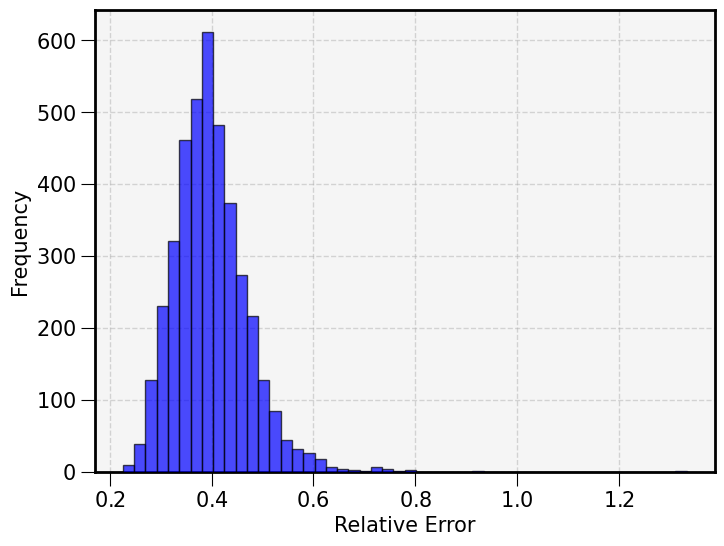

In [35]:
# List of corresponding relative errors
Error_rel = np.array(LSC_Report['Rn_Err']) / np.array(LSC_Report['Rn_CV'])

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.hist(Error_rel, bins=50, color='blue', alpha=0.7, edgecolor='black', lw=1.0, zorder=3)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

Let's plot all the LSC data and obtain a representative value per run.

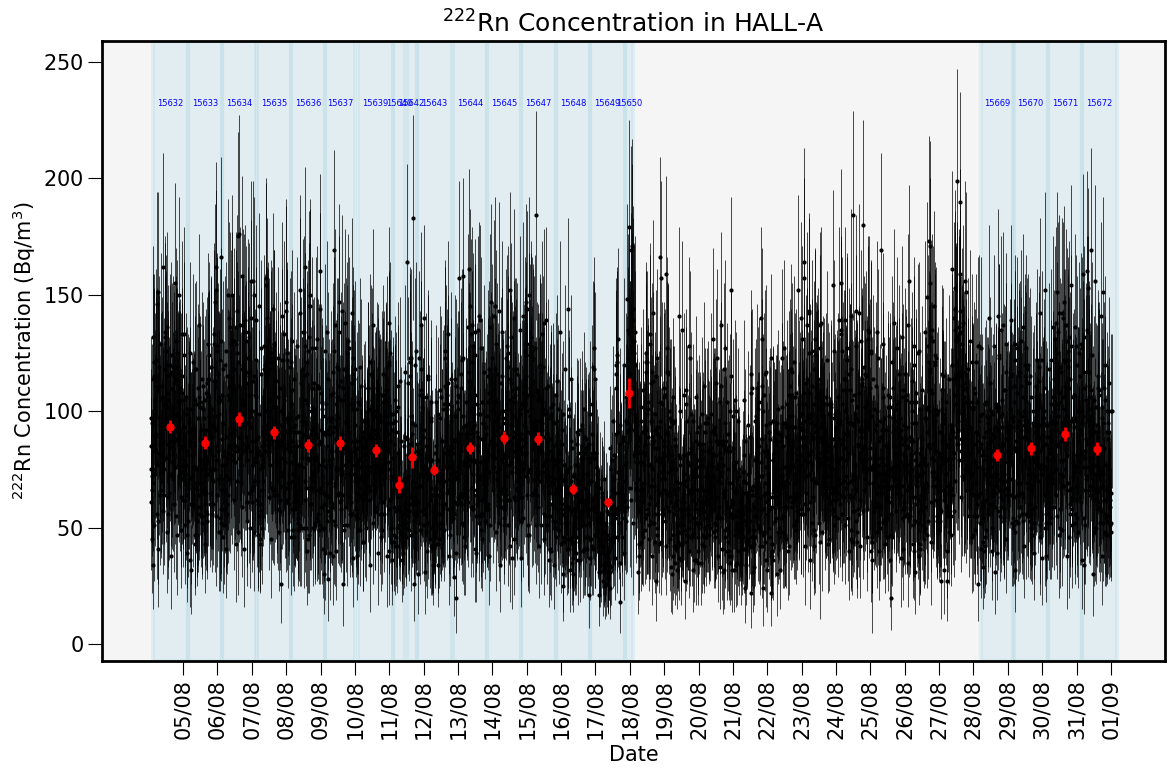

In [18]:
# Global
Date_LSC_CV  = []
Date_LSC_Err = []
Rn_LSC_CV    = []
Rn_LSC_Err   = []

plt.figure(figsize=(12, 8))

# ----- Runs Loop ----- #
for run_id in runs_info.keys():

    # Run information
    run_start = runs_info[run_id]['start']
    run_end   = runs_info[run_id]['end']
    
    # Plot the run period as a shaded area
    plt.axvspan(run_start, run_end, color='lightblue', alpha=0.25)
    plt.text((run_start + run_end) / 2, 230, str(run_id), 
             ha='center', va='bottom', fontsize=6, color='blue')
    
    # ----- Compute a CV for Rn Concentration ----- #
    # Find the closest value of LSC_report['Date'] to run_start and run_end
    start_closest = min(LSC_Report['Date'], key=lambda x: abs(x - run_start))
    end_closest   = min(LSC_Report['Date'], key=lambda x: abs(x - run_end))
    date_indices  = [i for i, t in enumerate(LSC_Report['Date']) if start_closest <= t <= end_closest]

    # Mean date + error per run
    x_values = [LSC_Report['Date'][i] for i in date_indices]
    Date_LSC_CV.append(np.mean(x_values))
    Date_LSC_Err.append(np.std(x_values) / np.sqrt(len(x_values)))

    # Weighted mean and error for Rn Concentration per run
    y_values = [LSC_Report['Rn_CV'][i] for i in date_indices]
    y_vars   = [LSC_Report['Rn_Err'][i]**2 for i in date_indices] 
    weights = [1 / var for var in y_vars]
    y_CV  = np.average(y_values, weights=None)
    y_err = np.sqrt(np.sum(y_vars)) / len(y_values)

    Rn_LSC_CV.append(y_CV)
    Rn_LSC_Err.append(y_err)

# LSC data
plt.errorbar(LSC_Report['Date'], LSC_Report['Rn_CV'], yerr=LSC_Report['Rn_Err'], fmt='o', ms=2, c='black', ecolor='black', elinewidth=0.5)
# Run data
plt.errorbar(Date_LSC_CV, Rn_LSC_CV, xerr=Date_LSC_Err, yerr=Rn_LSC_Err, fmt='o', ms=5, c='red', ecolor='red', zorder=3)

# ----- Styling ----- #
plt.xlabel('Date')
plt.ylabel(r'$^{222}$Rn Concentration (Bq/m$^3$)')
plt.title(r'$^{222}$Rn Concentration in HALL-A')

# Filter xticks to show only one per day at 12:00:00
dates_human = [crudo.epoch_converter(t, h=True) for t in LSC_Report['Date']]        #  Convert epoch time to human-readable format
# If they are just '12:00', check Crudo
noon_ticks  = [LSC_Report['Date'][i] for i in range(len(LSC_Report['Date'])) if dates_human[i].endswith('12:00')]
noon_labels = [dates_human[i].split(' - ')[0] for i in range(len(dates_human)) if dates_human[i].endswith('12:00')]
plt.xticks(ticks=noon_ticks, labels=noon_labels, rotation=90)

plt.gca().set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()

# Correlation

Fit results:
  b = (3.69 ± 0.06) mHz
χ² / ndof = 21.81 / 19.00 = 1.15
p-value = 0.2936


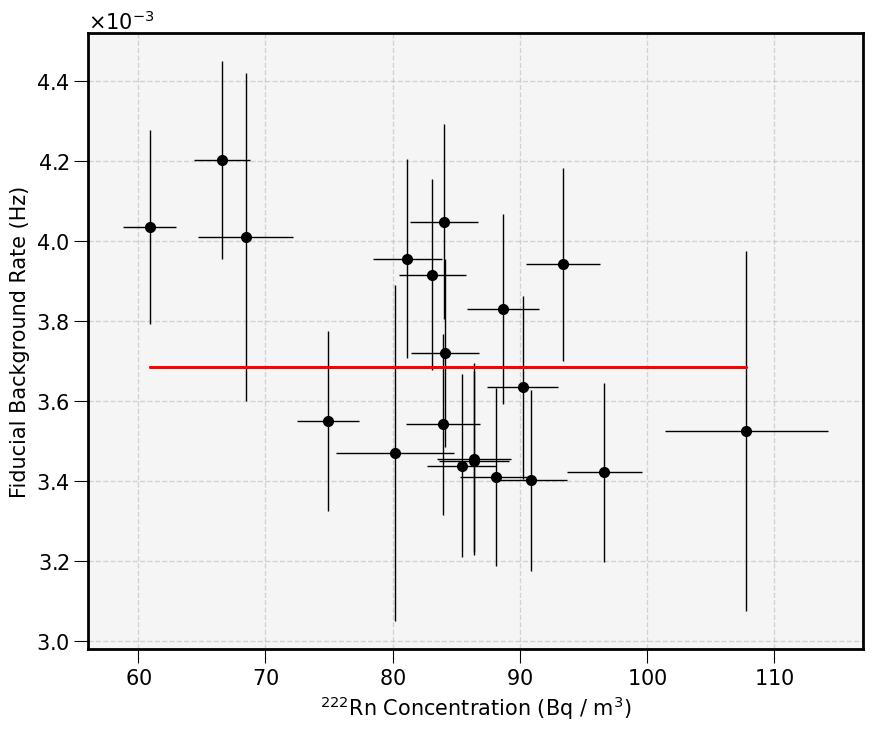

In [19]:
def const_func(x, b):
    return ff.linear_func(x, 0, b)

# ----- Linear Fit ----- #
# Preliminary
x_data   = np.array(Rn_LSC_CV)
x_errors = np.array(Rn_LSC_Err)
y_data   = np.array([Fiducial_Rate[run_id]['CV'] for run_id in runs_info.keys()])        # ESTOY REESCALANDO VALORES!
y_errors = np.array([Fiducial_Rate[run_id]['Error'] for run_id in runs_info.keys()])

# Define the cost function
# least_squares = LeastSquares(x_data, y_data, y_errors, ff.linear_func)
least_squares = LeastSquares(x_data, y_data, y_errors, const_func)

# Define the Minuit object with inital guesses for the parameters
# m = Minuit(least_squares, m=10, b=0)
m = Minuit(least_squares, b=0)

# Minimization process of the cost function and error estimation
m.migrad()
m.hesse()

# Reduced chi-square
chi2 = m.fval
ndof = len(x_data) - m.nfit
p_value = scipy.stats.chi2.sf(chi2, ndof)

print (f"Fit results:\n"
    #    f"  m = {m.values['m']:.6f} ± {m.errors['m']:.6f}\n"
       f"  b = ({m.values['b']*1e3:.2f} ± {m.errors['b']*1e3:.2f}) mHz\n"
       f"χ² / ndof = {chi2:.2f} / {ndof:.2f} = {chi2 / ndof:.2f}\n"
       f"p-value = {p_value:.4f}")

# ----- Plotting ----- #
# Data
plt.errorbar(x_data, y_data, xerr=x_errors, yerr=y_errors, fmt='o', color='black', ecolor='black', lw=1.0, label='Data')
# for x, y, run_id in zip(x_data, y_data, runs_info.keys()):
#     plt.text(x, y, str(run_id), fontsize=10, ha='right', va='bottom', color='blue')

# Fit
# y_fit = ff.linear_func(x_data, m.values['m'], m.values['b'])
y_fit = const_func(x_data, m.values['b'])
plt.plot(x_data, y_fit, color='red', ls='-', label=f"Linear fit\nb = ({m.values['b']*1e3:.2f} ± {m.errors['b']*1e3:.2f}) mHz\nχ² / ndof = {chi2 / ndof:.2f}")

# ----- Styling ----- #
plt.ylabel('Fiducial Background Rate (Hz)')
plt.xlabel(r'$^{222}$Rn Concentration (Bq / m$^3$)')
# plt.legend()

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.savefig('/lhome/ific/c/ccortesp/Analysis/NEXT-100/Backgrounds/images/RAS_On_Corr.pdf')
plt.show()